# pacpy demo
### Estimating phase-amplitude coupling (PAC) in simulated data
##### Scott Cole, 2015

The purpose of this notebook is to demonstrate the application of our publicly-available pacpy package. Here, we simulate the local field potential (LFP) of a series of neural populations with various levels of PAC. We then estimate the PAC with multiple metrics, noting tha they have differential sensitivities to the manipulation of the signal.

To run this in Binder, Click 'launch binder' on the repo [here](https://github.com/srcole/pacpybinder).

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from NeuroTools import stgen
from pacpy.pac import plv, mi_tort, mi_canolty, glm, ozkurt

C:\Users\Scott\Anaconda2\lib\site-packages\matplotlib\__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
C:\Users\Scott\Anaconda2\lib\site-packages\NeuroTools\__init__.py:125: DependencyWarning: ** interval ** package is not installed.
To have functions using interval please install the package.
website : http://pypi.python.org/pypi/interval/1.0.0

  warnings.warn(get_import_warning(name), DependencyWarning)


**Simulate spike trains**

An inhomogenous Poisson process generates spikes, using a sinusoidal time-varying rate

In [2]:
def pha2r(pha, method, mod_frac, firing_rate, sqprc=10.0, normstd = 1):
    '''
    Create a time-varying firing rate from a phase time series
    
    Parameters
    ----------
    pha : array
        time series of phases
    method : string
        'sin' or 'sq' for the firing rate modulation to be sinusoidal or square-wave shaped
    mod_frac : float
        Fraction of the total firing rate to be phase-modulated
    firing_rate : float
        Average firing rate
    sqprc : float (between 0 and 100)
        Percentage of the cycle to bias the firing if using the 'sq' method
        
    Returns
    -------
    r : array
        time series of instantaneous firing rates
    '''
    # Generate time series with mean 1 (1Hz)
    if method == 'sin':
        r_dep = np.sin(pha) + 1
        
    elif method == 'sq':
        sqpha_thresh = np.percentile(pha,sqprc)
        t_bias = pha < sqpha_thresh
        r_dep = t_bias * 100.0 / sqprc
        
    elif method == 'gauss':
        r_dep = mlab.normpdf(pha,0,normstd)
        r_dep = r_dep / np.mean(r_dep)
        
    
    # Normalize for firing rate
    r_dep = r_dep * firing_rate * mod_frac
    r_indep = firing_rate*(1-mod_frac) * np.ones(len(pha))
    r = r_dep + r_indep
    
    return r


def firf(x, f_range, fs, w=3):
    Ntaps = np.floor(w * fs / f_range[0])
    taps = sp.signal.firwin(Ntaps, np.array(f_range)/fs*2, pass_zero=False)
    return sp.signal.filtfilt(taps, [1], x)

def simthetaphase(T, flo = (4,8), dt=.001, returnthetawave=False):
    """ Simulate a theta oscillation
    Cut out first and last second to remove edge artifacts (very conservative time window for 4-8Hz)"""
    whitenoise = np.random.rand((T+2)/dt)
    theta = firf(whitenoise, flo, 1/dt)
    if returnthetawave:
        return np.angle(sp.signal.hilbert(theta[1/dt:(T+1)/dt])), theta[1/dt:(T+1)/dt]
    else:
        return np.angle(sp.signal.hilbert(theta[1/dt:(T+1)/dt]))

In [3]:
np.random.seed(1)
stg = stgen.StGen()

mod_frac = np.arange(0,1.01,.05) #Phase-dependent modulation is this fraction of spikes
flo = [4,8]
dt = .001
nNeu = 500
duty = 10


fractAMPA = .8 #4:1 ratio
frAMPA = 4
frGABA = 11
nNeuAMPA = int(np.round(fractAMPA*nNeu))
nNeuGABA = int(np.round((1-fractAMPA)*nNeu))

E = len(mod_frac)
S = 2
T = 5
t = np.arange(0,T,dt)

thetawave = np.zeros(E,dtype=object)
thetaphasesv = np.zeros(E,dtype=object)
spikesAMPA = np.zeros([E,S],dtype=object)
spikesGABA = np.zeros([E,S],dtype=object)
neusAMPA = np.zeros([E,S],dtype=object)
neusGABA = np.zeros([E,S],dtype=object)
for e in range(E):
    for s in range(S):
        # Simulate theta phase
        # Return theta wave for the first simulation condition
        if s==0:
            thetaphase, thetawave[e] = simthetaphase(T, flo = flo, dt=dt, returnthetawave=True)
            thetaphasesv[e] = thetaphase
        else:
            thetaphase = simthetaphase(T, flo = flo, dt=dt)
            
        # Calculate time-dependent firing rate
        rtAMPA = pha2r(thetaphase, 'sq', mod_frac[e], frAMPA, sqprc = duty)
        rtGABA = rtAMPA * (frGABA / frAMPA)
        
        # Simulate spiking
        spikesAMPA[e][s] = stg.inh_poisson_generator(rtAMPA*nNeuAMPA/dt,t,T,array=True)
        neusAMPA[e][s] = np.random.randint(0,nNeuAMPA,len(spikesAMPA[e][s]))
        
        # Simulate spiking
        spikesGABA[e][s] = stg.inh_poisson_generator(rtGABA*nNeuGABA/dt,np.arange(0,T,dt),T,array=True)
        neusGABA[e][s] = np.random.randint(0,nNeuGABA,len(spikesGABA[e][s]))

C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:53: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Scott\Anaconda2\lib\site-packages\NeuroTools\stgen.py:230: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  isi = self.rng.exponential(1.0/rate, number)*1000.0
C:\Users\Scott\Anaconda2\lib\site-packages\ipykernel\__main__.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


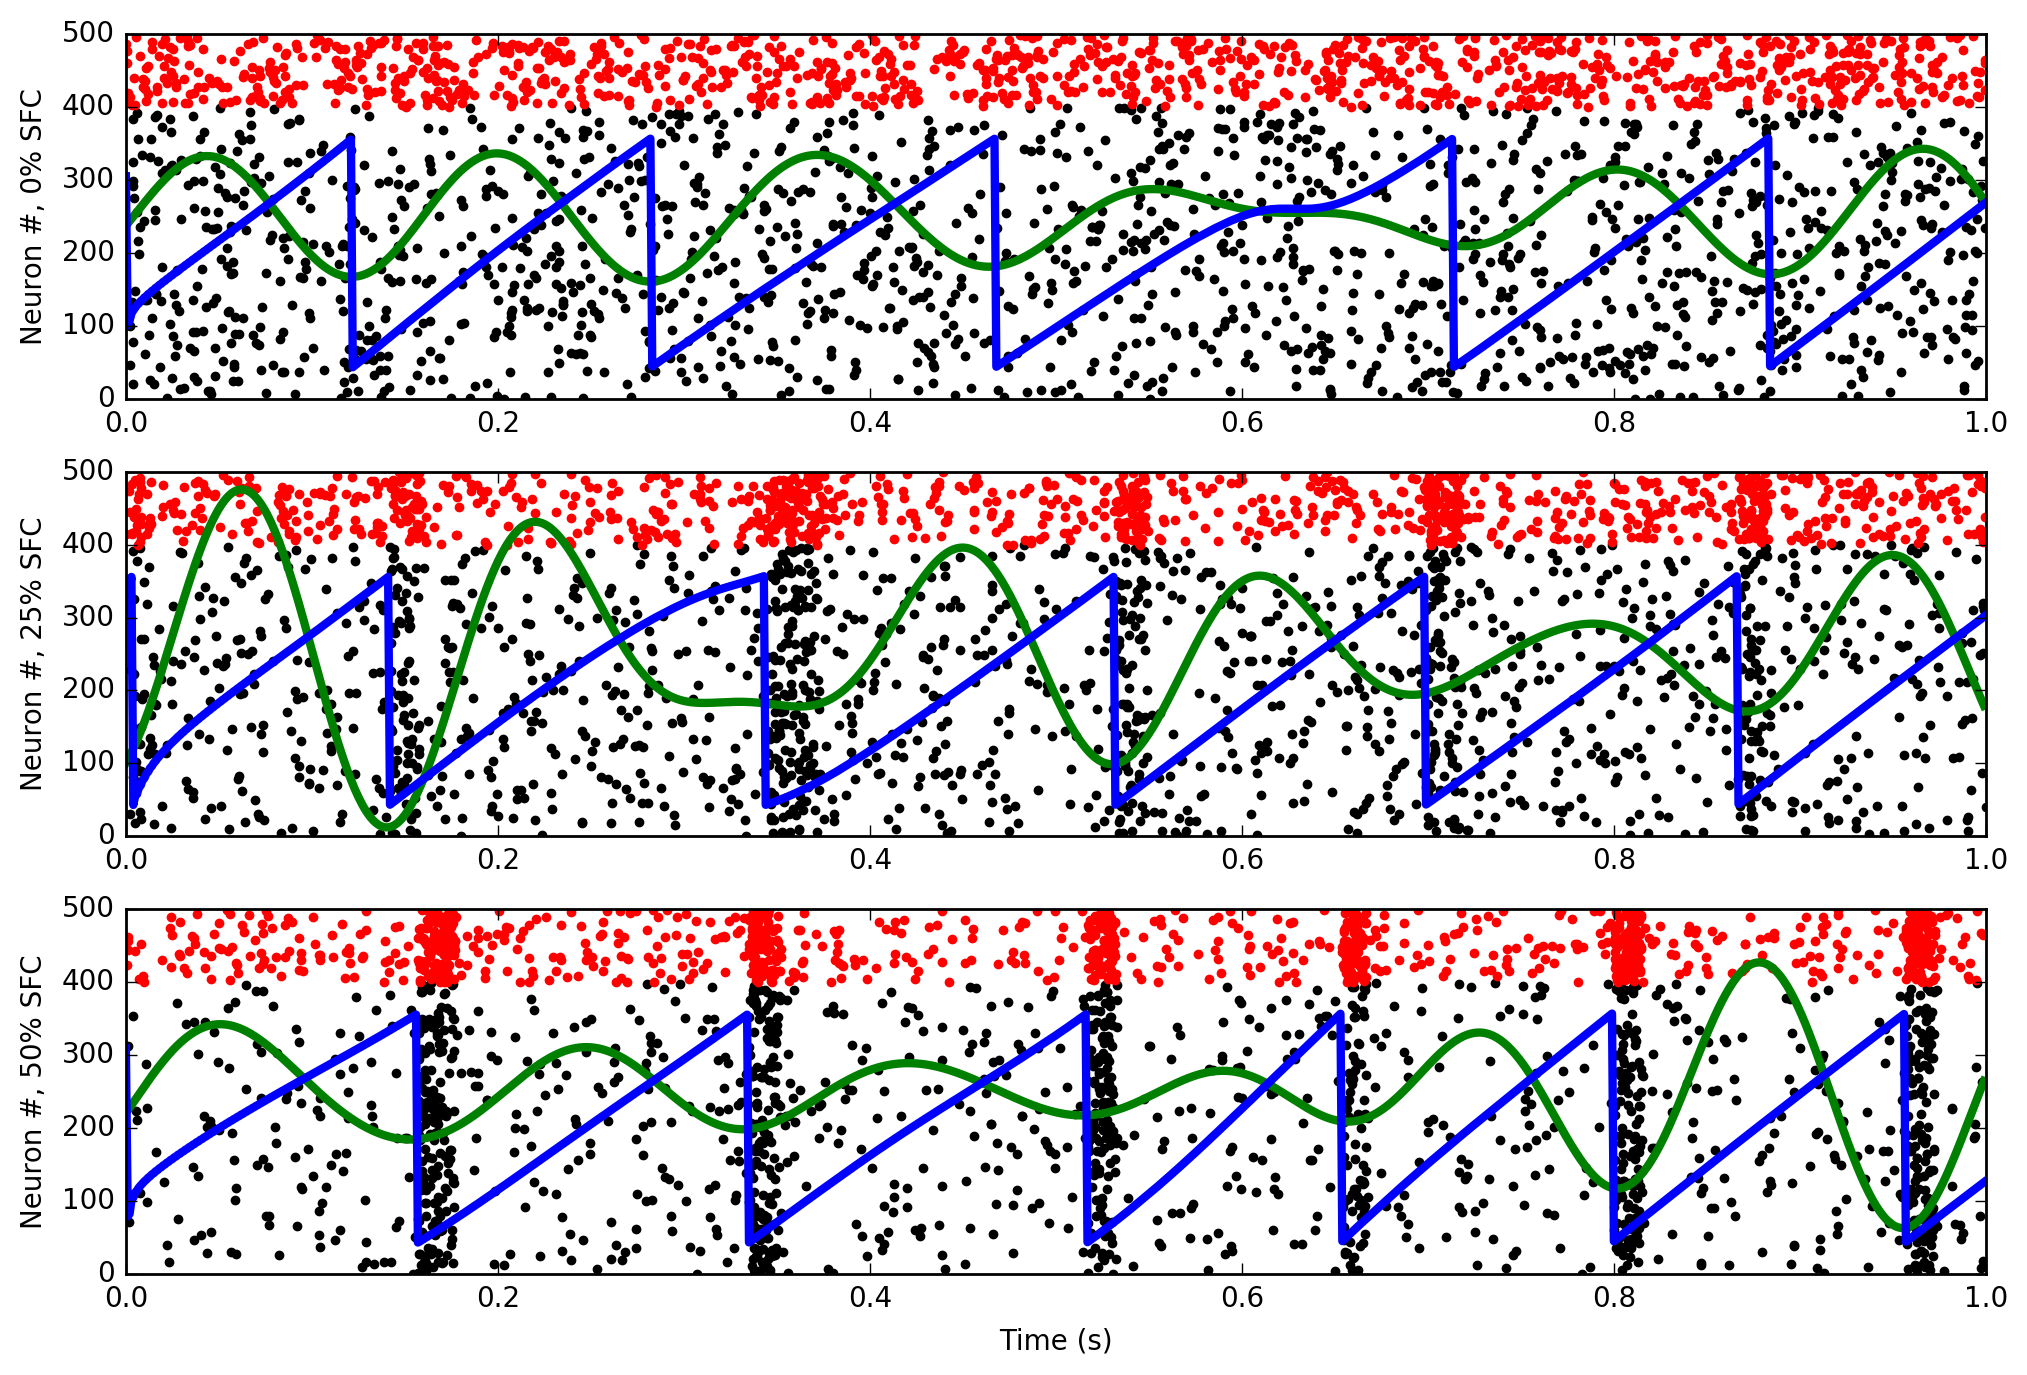

In [4]:
tmax = 1000
Eplot = [0,5,10]
Nplot = len(Eplot)

plt.figure(figsize=(12,8))
for e in range(Nplot):
    e2 = Eplot[e]
    plt.subplot(Nplot,1,e+1)
    plt.ylabel('Neuron #, ' + np.str(int(mod_frac[e2]*100))+'% SFC')
    plt.plot(spikesAMPA[e2][0][spikesAMPA[e2][0]<tmax*dt],neusAMPA[e2][0][spikesAMPA[e2][0]<tmax*dt],'k.')
    plt.plot(spikesGABA[e2][0][spikesGABA[e2][0]<tmax*dt],neusGABA[e2][0][spikesGABA[e2][0]<tmax*dt]+nNeuAMPA,'r.')
    plt.plot(t[:tmax],thetawave[e2][:tmax]*4000 + 250,'g',linewidth=3)
    plt.plot(t[:tmax],thetaphasesv[e2][:tmax]*50 + 200,'b',linewidth=3)
    plt.ylim((0,nNeu))
    if e == Nplot-1:
        plt.xlabel('Time (s)')
    

**Calculate LFP**

Convolve the spike train with kernels that represent AMPA and GABA synaptic potentials

In [5]:
# Define synaptic potential
gmax = 1
t_dexp = np.arange(200)

tau_riseG = 3
tau_decayG = 40
pspG = gmax * (np.exp(-t_dexp/tau_decayG) - np.exp(-t_dexp/tau_riseG))

tau_riseA = 0.5
tau_decayA = 1.5
pspA = gmax * (np.exp(-t_dexp/tau_decayA) - np.exp(-t_dexp/tau_riseA))

# Convert list of spike times to an LFP
lfp = np.zeros([E,S,int(T/dt)])
for e in range(E):
    for s in range(S):
        splistA, _ = np.histogram(spikesAMPA[e][s],np.arange(0,T+dt,dt))
        splistG, _ = np.histogram(spikesGABA[e][s],np.arange(0,T+dt,dt))
        lfp[e,s] = -np.convolve(splistA,pspA,mode='same') + \
                    np.convolve(splistG,pspG,mode='same')

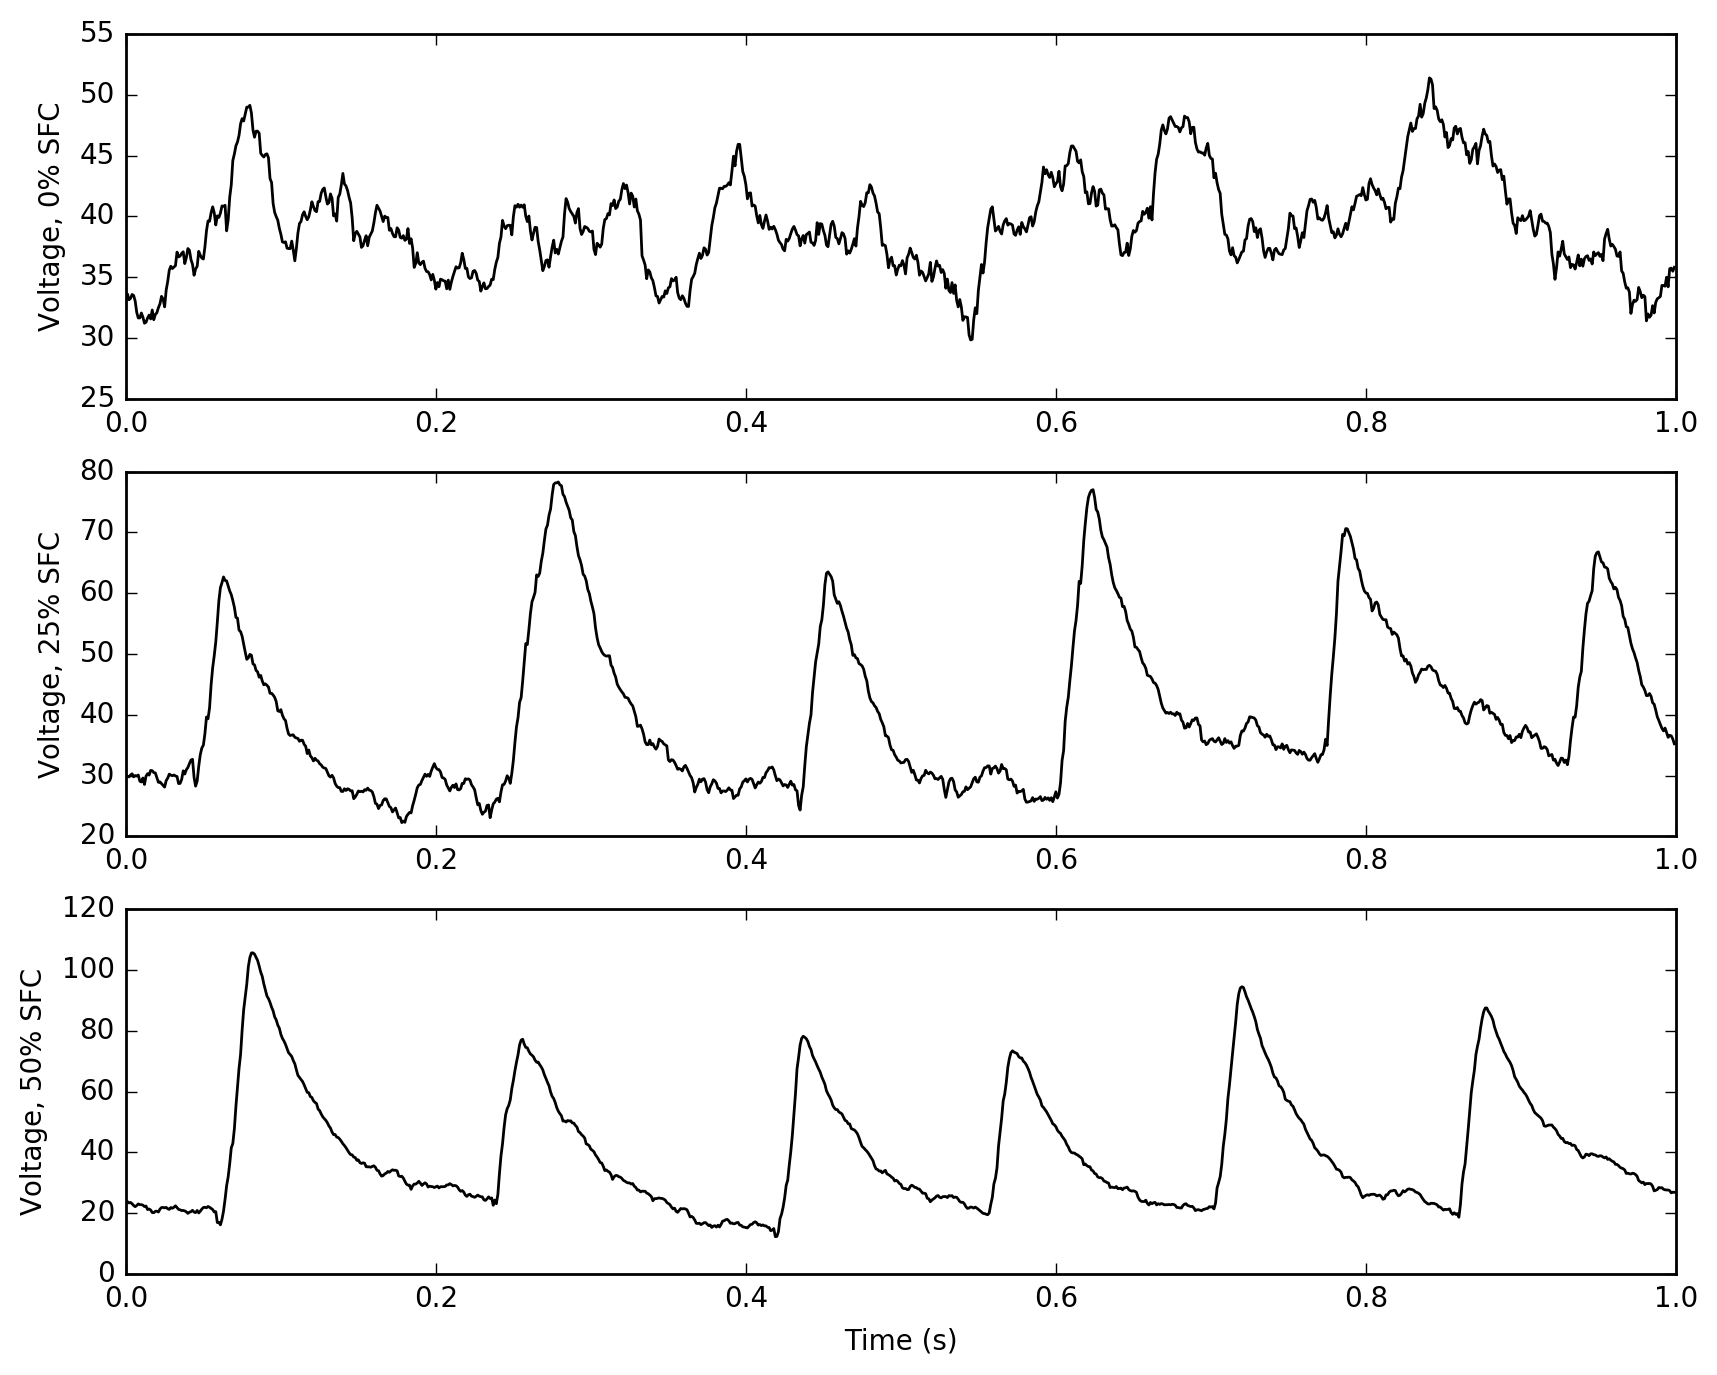

In [6]:
plt.figure(figsize = (10,8))
for e in range(Nplot):
    e2 = Eplot[e]
    plt.subplot(Nplot,1,e+1)
    plt.plot(t[:tmax],lfp[e2][0][:tmax],'k')
    plt.ylabel('Voltage, ' + np.str(int(mod_frac[e2]*100))+'% SFC')
    if e == Nplot-1:
        plt.xlabel('Time (s)')

**Calculate PAC**

Calculate phase-amplitude coupling using 5 methods in pacpy

In [7]:
Fs = 1/dt
f_hi = [80, 200]
f_lo = flo
kwargs = {'w_lo' : 7, 'filt_method' : 'fir'}

pac_plv = np.zeros([S,E])
pac_cmi = np.zeros([S,E])
pac_glm = np.zeros([S,E])
pac_tort = np.zeros([S,E])
pac_ozk = np.zeros([S,E])
for e in range(E):
    for fr in range(S):
        pac_plv[fr][e] = plv(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_tort[fr][e] = mi_tort(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_cmi[fr][e] = mi_canolty(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_glm[fr][e] = glm(lfp[e][fr],lfp[e][fr], f_lo, f_hi)
        pac_ozk[fr][e] = ozkurt(lfp[e][fr],lfp[e][fr], f_lo, f_hi)

Visualize relationship between firing bias and each PAC metric

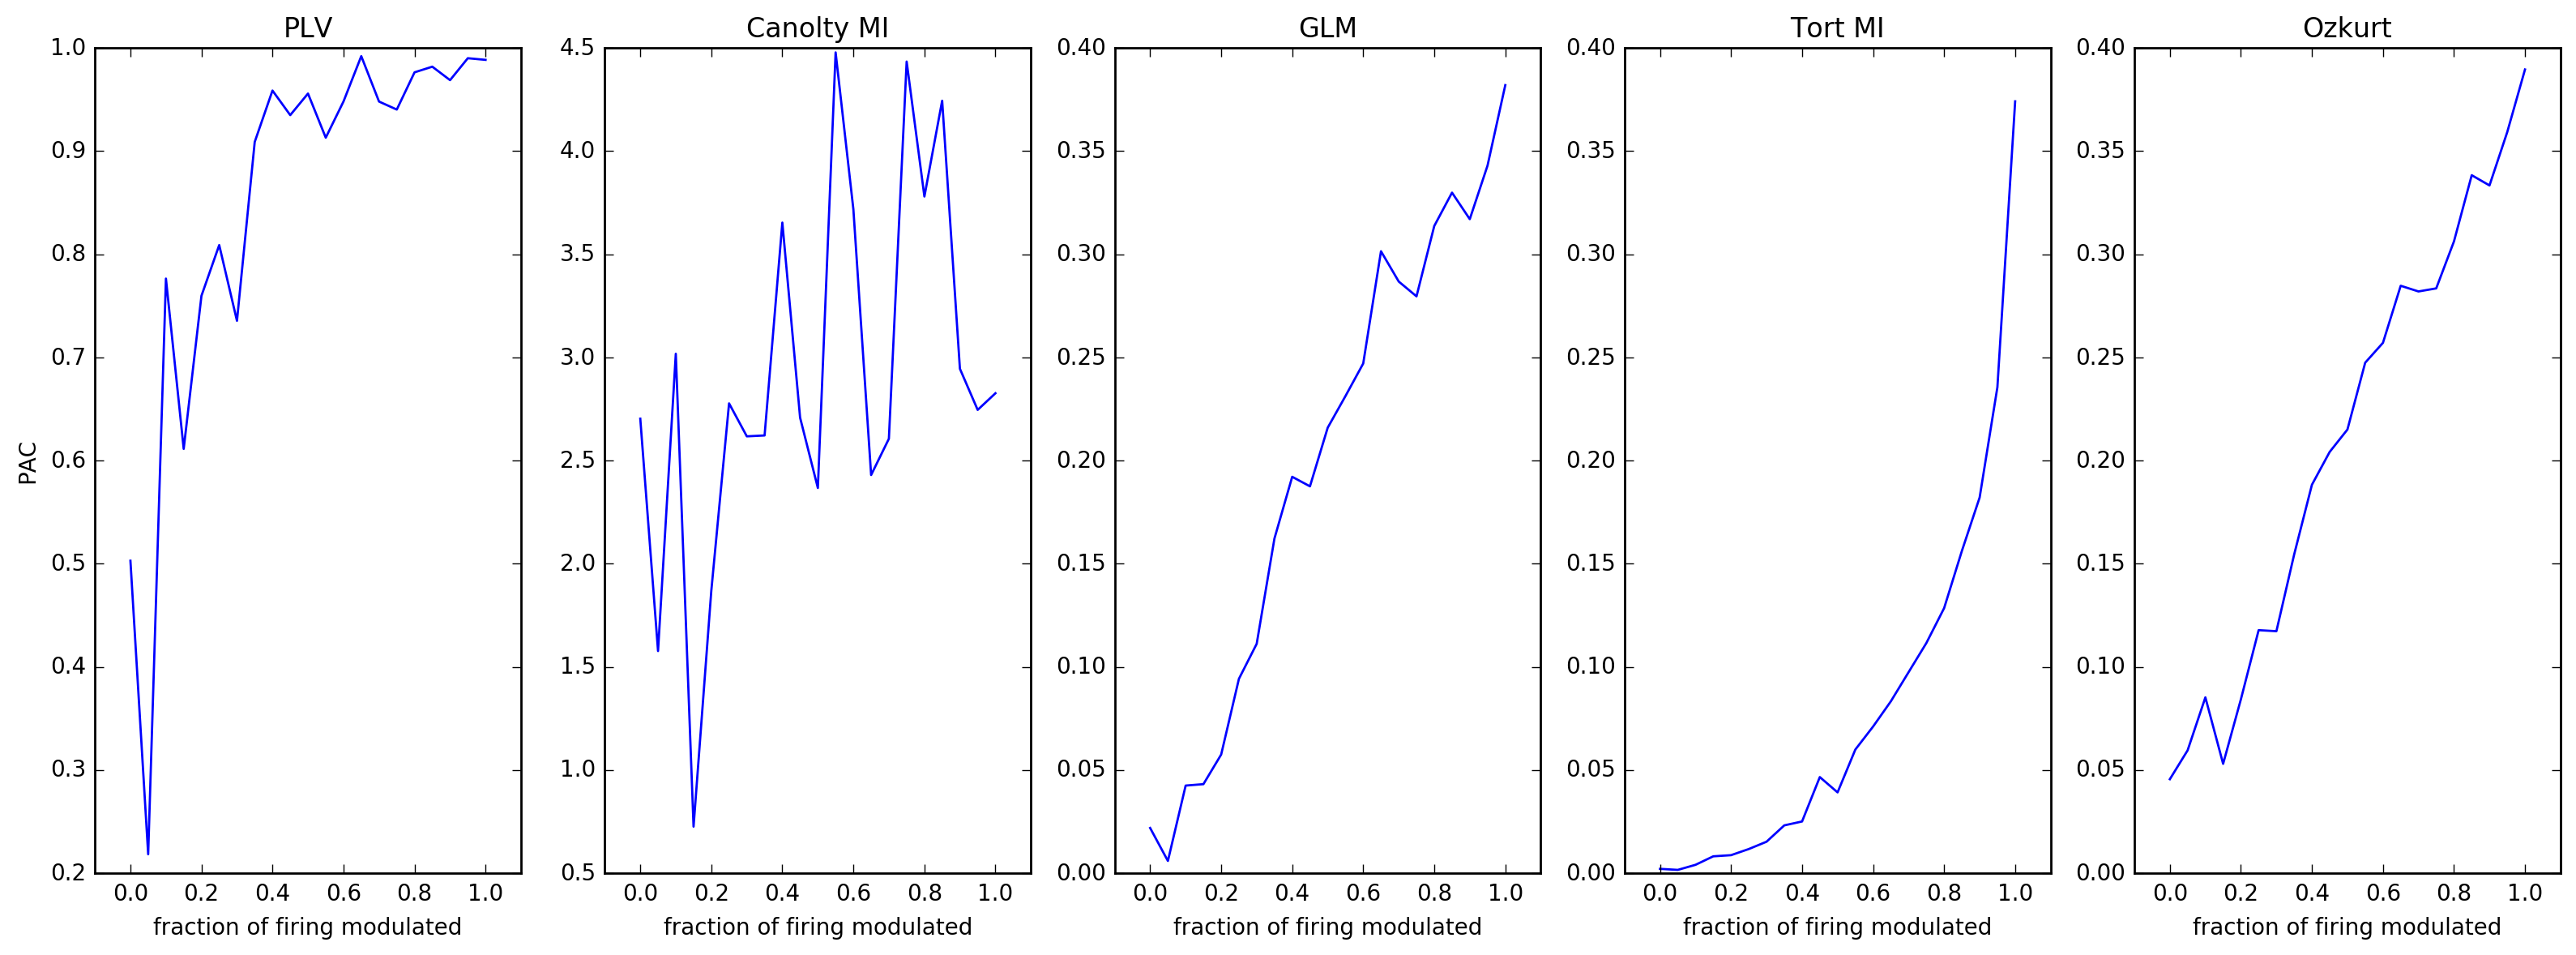

In [8]:
plt.figure(figsize=(16,6))
plt.subplot(1,5,1)
plt.plot(mod_frac,pac_plv[0])
plt.xlabel('fraction of firing modulated')
plt.ylabel('PAC')
plt.title('PLV')
plt.xlim([-.1,1.1])
plt.tight_layout()

plt.subplot(1,5,2)
plt.plot(mod_frac,pac_cmi[0])
plt.xlabel('fraction of firing modulated')
plt.title('Canolty MI')
plt.xlim([-.1,1.1])
plt.tight_layout()

plt.subplot(1,5,3)
plt.plot(mod_frac,pac_glm[0])
plt.xlabel('fraction of firing modulated')
plt.title('GLM')
plt.xlim([-.1,1.1])
plt.tight_layout()

plt.subplot(1,5,4)
plt.plot(mod_frac,pac_tort[0])
plt.xlabel('fraction of firing modulated')
plt.title('Tort MI')
plt.xlim([-.1,1.1])
plt.tight_layout()

plt.subplot(1,5,5)
plt.plot(mod_frac,pac_ozk[0])
plt.xlabel('fraction of firing modulated')
plt.title('Ozkurt')
plt.xlim([-.1,1.1])
plt.tight_layout()